In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
data = pd.read_csv("../semi_filled.csv")
data = data.set_index(pd.to_datetime(data['date']))
data.describe()

,BC,N_CPC,PM-10,PM-2.5,PM-1.0,NO2,O3,SO2,CO,NO,NOX,TEMP,HUM
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000
mean,1.290458,13.391284,14.815418,9.225246,7.186021,29.776484,48.090900,1.354456,0.305521,7.482184,40.881033,17.890157,71.109916
std,1.069422,7.939834,13.228728,5.805274,5.204188,21.164979,25.864992,0.786532,0.201884,17.066756,43.034981,6.071411,14.935135
min,0.110000,1.376000,0.600000,0.500000,0.333000,2.000000,1.000000,0.500000,0.100000,0.500000,1.000000,4.083000,19.383000
25%,0.664000,7.673750,8.783000,5.200000,3.333000,15.000000,31.000000,1.000000,0.200000,1.000000,17.000000,12.833000,60.962750
50%,0.975000,11.427000,12.883000,7.967000,5.917000,24.000000,48.000000,1.000000,0.200000,3.000000,28.000000,17.250000,72.183000
75%,1.487000,17.188250,18.050000,11.767000,9.450000,39.000000,65.000000,2.000000,0.300000,6.000000,47.000000,22.817000,83.071000
max,12.767000,73.490000,398.717000,76.833000,33.850000,132.000000,142.000000,13.000000,1.900000,255.000000,521.000000,33.583000,100.000000


In [4]:
data = data.sort_index()
data = data.reset_index(drop=True)
dates = data["date"]
data = data.drop(["date"], axis=1)

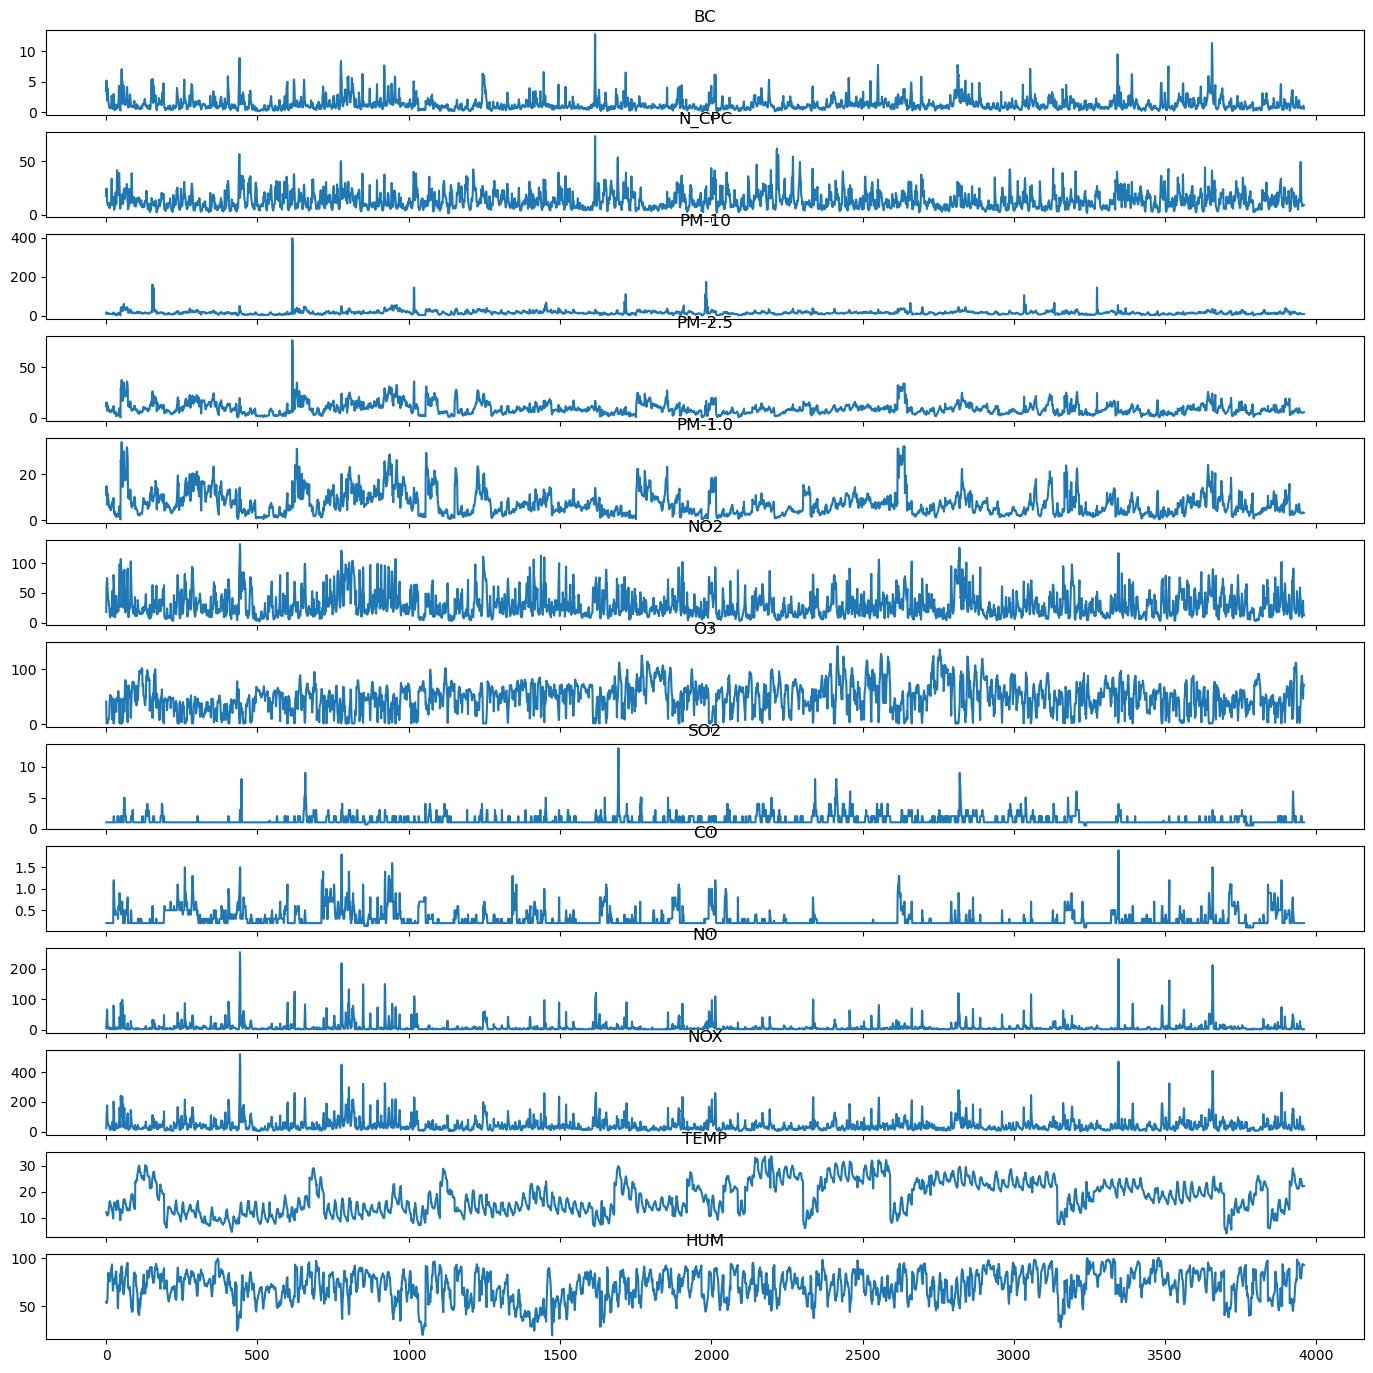

In [5]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(data, data.columns)

threshold = 6 # theshold a little high to retain some outliers
z_scores = np.abs((data - data.mean()) / data.std())
outliers = (z_scores > threshold).any(axis=1)
for column in data.columns:
    column_median = data[column].median()
    data.loc[outliers, column] = column_median

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') #disables GPU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Normalization

In [7]:
data.columns

Index(['BC', 'N_CPC', 'PM-10', 'PM-2.5', 'PM-1.0', 'NO2', 'O3', 'SO2', 'CO',
       'NO', 'NOX', 'TEMP', 'HUM'],
      dtype='object')

In [8]:
# Scale the data to the range of [0, 1] for better performance
scaler = StandardScaler(with_mean=False)
scaled_data = scaler.fit_transform(data)

In [19]:
# split into train and test sets
n_train_hours = 140 * 24
train = scaled_data[:n_train_hours, :]
test = scaled_data[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 24, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 24, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



ValueError: cannot reshape array of size 40320 into shape (24,12)

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length - 1):
        x.append(data[i:i+seq_length, 1:])  # Exclude BC concentration from input features
        y.append(data[i:i+seq_length, 0])  # BC concentration as the target variable
    return np.array(x), np.array(y)

seq_length = 24*2
x, y = create_sequences(scaled_data, seq_length)

# Split the dataset into training and validation sets
train_size = int(len(y) * 0.85)
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

In [15]:
model = Sequential()
model.add(Normalization())
model.add(LSTM(50, input_shape=(n_train_hours, train_X.shape[2]), return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(30, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(30))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.001)

In [17]:
history = model.fit(train_X, train_y, epochs=500, batch_size=24, validation_data=(test_X, test_y), callbacks=[reduce_lr, early_stopping], use_multiprocessing=True)

Epoch 1/500
105/105 [==============================] - 2s 6ms/step - loss: 0.8803 - val_loss: 0.5965 - lr: 0.0010
Epoch 2/500
105/105 [==============================] - 0s 1ms/step - loss: 0.4383 - val_loss: 0.4361 - lr: 0.0010
Epoch 3/500
105/105 [==============================] - 0s 1ms/step - loss: 0.3615 - val_loss: 0.3873 - lr: 0.0010
Epoch 4/500
105/105 [==============================] - 0s 1ms/step - loss: 0.3391 - val_loss: 0.3828 - lr: 0.0010
Epoch 5/500
105/105 [==============================] - 0s 1ms/step - loss: 0.3202 - val_loss: 0.3442 - lr: 0.0010
Epoch 6/500
105/105 [==============================] - 0s 1ms/step - loss: 0.3141 - val_loss: 0.3704 - lr: 0.0010
Epoch 7/500
105/105 [==============================] - 0s 1ms/step - loss: 0.3130 - val_loss: 0.3690 - lr: 0.0010
Epoch 8/500
105/105 [==============================] - 0s 1ms/step - loss: 0.3001 - val_loss: 0.3178 - lr: 0.0010
Epoch 9/500
105/105 [==============================] - 0s 1ms/step - loss: 0.2909 - val_

In [88]:
y_pred = model.predict(test_X)

16/16 [==============================] - 0s 637us/step


In [92]:
y_pred.shape

(504, 1)

In [94]:
test_y.reshape(-1, 1).shape

(504, 1)

[ 0.342       0.36        0.376       0.546       1.133       2.046
  4.28        4.808       4.792       3.133       1.417       0.935
  0.658       0.629       0.96922685  1.13934028  1.08722685  0.865
  1.702       3.179       2.09        1.709       0.518       0.381
  0.334       0.381       0.315       0.87        0.726       1.561
  5.687       7.474       0.862       0.852       0.752       0.965
  0.832       0.529       0.537       0.746       0.662       0.613
  0.616       0.91        1.098       0.878       0.552       0.441
  0.26        0.332       0.286       0.329       0.632       1.022
  1.486       0.769       1.086       0.829       0.954       1.082
  0.949       1.532       1.923       1.575       2.081       2.698
  3.075       2.321       2.013       2.396       2.366       2.356
  2.406       2.058       1.663       1.857       1.671       1.845
  2.641       4.643       4.732       1.151       1.688       1.04
  0.959       0.81        1.372       0.672      

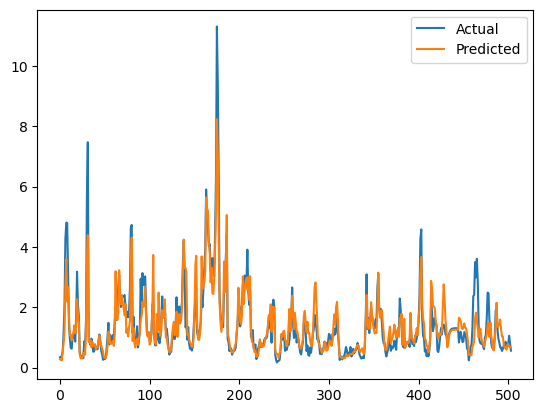

In [97]:
y_val_actual = scaler.inverse_transform(np.hstack((test_y[:].reshape(-1, 1), test_X[:, -1])))[:, 0]
y_pred_actual = scaler.inverse_transform(np.hstack((y_pred[:, -1].reshape(-1, 1), test_X[:, -1])))[:, 0]

print(y_val_actual)
print(y_pred_actual)

mae = mean_absolute_error(y_val_actual, y_pred_actual)
mse = mean_squared_error(y_val_actual, y_pred_actual)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

# Visualize the model's predictions
plt.plot(y_val_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.legend()
plt.show()